**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, roc_curve

**Load Dataset**

In [ ]:
# Define paths to train, valid, and test datasets
train_dir = '/content/drive/MyDrive/Practice/datasets/train'
valid_dir = '/content/drive/MyDrive/Practice/datasets/valid'
test_dir = '/content/drive/MyDrive/Practice/datasets/test'

# Image augmentation for train data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescaling for validation and test data
valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load datasets
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_data = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

# # Load datasets with binary classification
# train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
# valid_data = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
# test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

Found 1500 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


**Load Pre-Trained VGG16 Model**

In [ ]:
# Load pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print(base_model.summary())

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


**Build Custom Model**

In [ ]:
# Add custom layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)  # 3 classes: cats, dogs, snakes
# output = Dense(1, activation='sigmoid')(x)  # 1 neuron for binary classification
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,170,755 (80.76 MB)

 Trainable params: 6,456,067 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Train the Model**

In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=5,  # Adjust the number of epochs
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=valid_data.samples // valid_data.batch_size
)

# Print training accuracy and validation accuracy after each epoch
print("Training and Validation Accuracy per Epoch:")
for epoch in range(len(history.history['accuracy'])):
    print(f"Epoch {epoch + 1}: Training Accuracy = {history.history['accuracy'][epoch]:.2f}, "
          f"Validation Accuracy = {history.history['val_accuracy'][epoch]:.2f}")

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 1646s 35s/step - accuracy: 0.5984 - loss: 1.4637 - val_accuracy: 0.9129 - val_loss: 0.2534
Epoch 2/5
 1/46 ━━━━━━━━━━━━━━━━━━━━ 16:32 22s/step - accuracy: 0.8438 - loss: 0.4700

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 357ms/step - accuracy: 0.8438 - loss: 0.4700 - val_accuracy: 1.0000 - val_loss: 0.2428
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1581s 34s/step - accuracy: 0.8483 - loss: 0.3539 - val_accuracy: 0.8560 - val_loss: 0.3663
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.7812 - loss: 0.5715 - val_accuracy: 0.7500 - val_loss: 1.0173
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1560s 34s/step - accuracy: 0.8659 - loss: 0.3089 - val_accuracy: 0.8337 - val_loss: 0.4320
Training and Validation Accuracy per Epoch:
Epoch 1: Training Accuracy = 0.74, Validation Accuracy = 0.91
Epoch 2: Training Accuracy = 0.84, Validation Accuracy = 1.00
Epoch 3: Training Accuracy = 0.85, Validation Accuracy = 0.86
Epoch 4: Training Accuracy = 0.78, Validation Accuracy = 0.75
Epoch 5: Training Accuracy = 0.85, Validation Accuracy = 0.83


**Evaluate the Model**

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 436s 22s/step - accuracy: 0.8632 - loss: 0.3490
Test Accuracy: 87.17%


In [ ]:
# Evaluate the model on the test data
test_images, test_labels = next(test_data)  # Get a batch of test data
y_pred_test = model.predict(test_images)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)  # Convert predictions to class indices
y_true_test = np.argmax(test_labels, axis=1)  # Convert one-hot labels to indices

# Overall accuracy
accuracy = accuracy_score(y_true_test, y_pred_classes_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
Test Accuracy: 96.88%


In [ ]:
# # Evaluate the model on the entire test dataset
# y_true_test_all = []
# y_pred_classes_test_all = []

# for test_images, test_labels in test_data:  # Iterate over all batches
#     y_pred_test = model.predict(test_images)
#     y_pred_classes_test = np.argmax(y_pred_test, axis=1)
#     y_true_test = np.argmax(test_labels, axis=1)

#     # Collect predictions and true labels
#     y_pred_classes_test_all.extend(y_pred_classes_test)
#     y_true_test_all.extend(y_true_test)

# # Convert lists to numpy arrays
# y_true_test_all = np.array(y_true_test_all)
# y_pred_classes_test_all = np.array(y_pred_classes_test_all)

# # Overall accuracy
# accuracy = accuracy_score(y_true_test_all, y_pred_classes_test_all)
# print(f"Test Accuracy on Entire Dataset: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━

In [ ]:
# Predict on the entire test dataset
y_pred_test_all = model.predict(test_data)  # Predict probabilities for all test samples

# Convert predictions to class indices
y_pred_classes_test_all = np.argmax(y_pred_test_all, axis=1)

# Extract true labels from the test dataset
y_true_test_all = np.concatenate([np.argmax(labels, axis=1) for _, labels in test_data], axis=0)

# Overall accuracy
accuracy = accuracy_score(y_true_test_all, y_pred_classes_test_all)
print(f"Test Accuracy on Entire Dataset: {accuracy * 100:.2f}%")

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
metrics = model.evaluate(test_data, return_dict=True)
print(f"Test Accuracy: {metrics['accuracy'] * 100:.2f}%")
print(f"Test Precision: {metrics['precision']:.4f}")
print(f"Test Recall: {metrics['recall']:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 395s 21s/step - accuracy: 0.8904 - loss: 0.3423 - precision: 0.8991 - recall: 0.8813
Test Accuracy: 87.17%
Test Precision: 0.8812
Test Recall: 0.8650


In [ ]:
# Map test dataset to extract predictions and labels in one pass
y_true_test_all, y_pred_classes_test_all = [], []

for images, labels in test_data:
    y_pred = model.predict(images)
    y_true_test_all.extend(np.argmax(labels, axis=1))
    y_pred_classes_test_all.extend(np.argmax(y_pred, axis=1))

# Convert to numpy arrays for compatibility
y_true_test_all = np.array(y_true_test_all)
y_pred_classes_test_all = np.array(y_pred_classes_test_all)

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_true_test_all, y_pred_classes_test_all)
print(f"Test Accuracy on Entire Dataset: {accuracy * 100:.2f}%")

In [ ]:
# Evaluate the model to get loss and accuracy
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict to calculate other metrics
y_pred_test_all = model.predict(test_data)
y_pred_classes_test_all = np.argmax(y_pred_test_all, axis=1)
y_true_test_all = np.concatenate([np.argmax(labels, axis=1) for _, labels in test_data], axis=0)

# Additional metrics (Precision, Recall, F1-Score)
from sklearn.metrics import classification_report
print(classification_report(y_true_test_all, y_pred_classes_test_all, target_names=['Class 0', 'Class 1', 'Class 2']))

19/19 ━━━━━━━━━━━━━━━━━━━━ 393s 21s/step - accuracy: 0.8592 - loss: 0.3854 - precision: 0.8687 - recall: 0.8547


ValueError: too many values to unpack (expected 2)

In [ ]:
# Predict on the entire test dataset
y_pred_test_all = model.predict(test_data)  # Get predictions for all samples in the test dataset

# Convert predictions to class indices
y_pred_classes_test = np.argmax(y_pred_test_all, axis=1)

# Extract true labels from the test dataset
y_true_test = np.concatenate([np.argmax(labels, axis=1) for _, labels in test_data], axis=0)

# Calculate accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_true_test, y_pred_classes_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, F1-score, and more
print("\nClassification Report:")
print(classification_report(y_true_test, y_pred_classes_test, target_names=['Class 0', 'Class 1', 'Class 2']))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_test, y_pred_classes_test)
print(cm)

19/19 ━━━━━━━━━━━━━━━━━━━━ 396s 21s/step


**Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, roc_curve

# Calculate and print the confusion matrix
cm_test = confusion_matrix(y_true_test, y_pred_classes_test)
print("Confusion Matrix on Test Data:")
print(cm_test)

# Classification Report (includes class-wise precision, recall, F1-score)
report_test = classification_report(y_true_test, y_pred_classes_test, target_names=['cats', 'dogs', 'snakes'])
print("Classification Report on Test Data:")
print(report_test)

# Extract individual class-wise metrics from the classification report
report_dict_test = classification_report(
    y_true_test, y_pred_classes_test, target_names=['cats', 'dogs', 'snakes'], output_dict=True
)

# Print individual class metrics
for class_name, metrics in report_dict_test.items():
    if class_name in ['cats', 'dogs', 'snakes']:
        print(f"Class: {class_name}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-Score: {metrics['f1-score']:.4f}")
        print()

# Overall metrics (macro average)
macro_precision = report_dict_test['macro avg']['precision']
macro_recall = report_dict_test['macro avg']['recall']
macro_f1 = report_dict_test['macro avg']['f1-score']

print(f"Overall Precision (Macro avg): {macro_precision:.4f}")
print(f"Overall Recall (Macro avg): {macro_recall:.4f}")
print(f"Overall F1-Score (Macro avg): {macro_f1:.4f}")

# AUC-ROC for Test Data (One-vs-Rest approach for multi-class classification)
y_true_test_bin = label_binarize(y_true_test, classes=[0, 1, 2])  # Assuming 3 classes
roc_auc_scores = []

for i in range(3):  # For each class
    fpr, tpr, _ = roc_curve(y_true_test_bin[:, i], y_pred_test[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)
    print(f"AUC-ROC for Class {i} ({['cats', 'dogs', 'snakes'][i]}): {roc_auc:.4f}")

# Macro average AUC-ROC
roc_auc_macro = np.mean(roc_auc_scores)
print(f"Macro Average AUC-ROC: {roc_auc_macro:.4f}")

# Weighted average AUC-ROC
roc_auc_weighted = np.average(roc_auc_scores, weights=[sum(y_true_test == i) for i in range(3)])
print(f"Weighted Average AUC-ROC: {roc_auc_weighted:.4f}")

Confusion Matrix on Test Data:
[[ 9  0  0]
 [ 1 16  0]
 [ 0  0  6]]
Classification Report on Test Data:
              precision    recall  f1-score   support

        cats       0.90      1.00      0.95         9
        dogs       1.00      0.94      0.97        17
      snakes       1.00      1.00      1.00         6

    accuracy                           0.97        32
   macro avg       0.97      0.98      0.97        32
weighted avg       0.97      0.97      0.97        32

Class: cats
  Precision: 0.9000
  Recall: 1.0000
  F1-Score: 0.9474

Class: dogs
  Precision: 1.0000
  Recall: 0.9412
  F1-Score: 0.9697

Class: snakes
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Overall Precision (Macro avg): 0.9667
Overall Recall (Macro avg): 0.9804
Overall F1-Score (Macro avg): 0.9724
AUC-ROC for Class 0 (cats): 0.9855
AUC-ROC for Class 1 (dogs): 0.9882
AUC-ROC for Class 2 (snakes): 1.0000
Macro Average AUC-ROC: 0.9912
Weighted Average AUC-ROC: 0.9897


**Save the Model**

In [ ]:
model.save('vgg16_cats_dogs_snakes.h5')

**Inference**

In [ ]:
# Load the saved model
model = load_model('vgg16_cats_dogs_snakes.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Snake


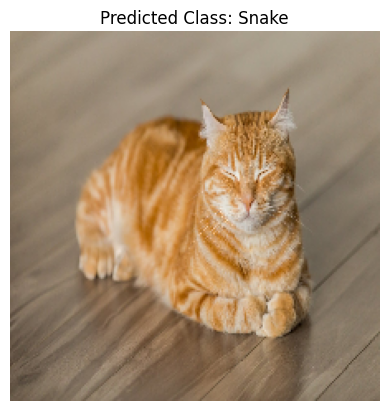

In [ ]:
image_path = '/content/drive/MyDrive/Practice/gyan/1.jpg'
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = image_array / 255.0
prediction = model.predict(image_array)
predicted_class_index = np.argmax(prediction)
class_names = ['Cat', 'Dog', 'Snake']  # Ensure these match your training classes
print(f"Predicted Class: {class_names[predicted_class_index]}")
# Display the image
plt.imshow(image)
plt.title(f"Predicted Class: {class_names[predicted_class_index]}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Class: Cat


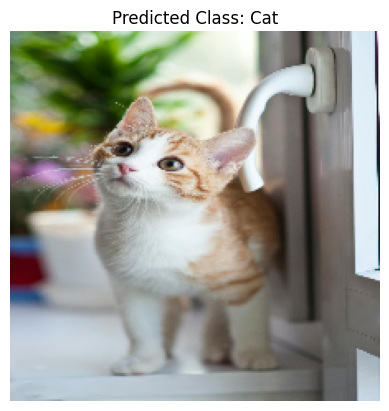

In [ ]:
image_path = '/content/drive/MyDrive/Practice/gyan/3.jpg'
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = image_array / 255.0
prediction = model.predict(image_array)
predicted_class_index = np.argmax(prediction)
class_names = ['Cat', 'Dog', 'Snake']  # Ensure these match your training classes
print(f"Predicted Class: {class_names[predicted_class_index]}")
# Display the image
plt.imshow(image)
plt.title(f"Predicted Class: {class_names[predicted_class_index]}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Class: Dog


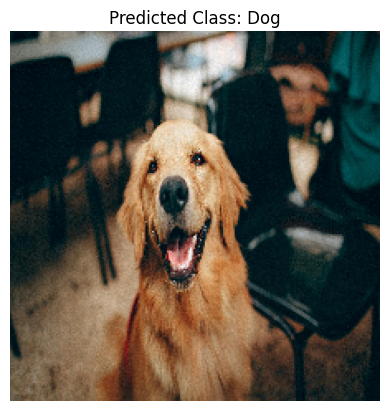

In [ ]:
image_path = '/content/drive/MyDrive/Practice/gyan/5.jpg'
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = image_array / 255.0
prediction = model.predict(image_array)
predicted_class_index = np.argmax(prediction)
class_names = ['Cat', 'Dog', 'Snake']  # Ensure these match your training classes
print(f"Predicted Class: {class_names[predicted_class_index]}")
# Display the image
plt.imshow(image)
plt.title(f"Predicted Class: {class_names[predicted_class_index]}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Class: Snake


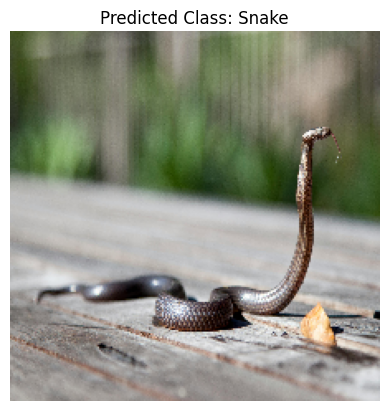

In [ ]:
image_path = '/content/drive/MyDrive/Practice/gyan/7.jpg'
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = image_array / 255.0
prediction = model.predict(image_array)
predicted_class_index = np.argmax(prediction)
class_names = ['Cat', 'Dog', 'Snake']  # Ensure these match your training classes
print(f"Predicted Class: {class_names[predicted_class_index]}")
# Display the image
plt.imshow(image)
plt.title(f"Predicted Class: {class_names[predicted_class_index]}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Class: Snake


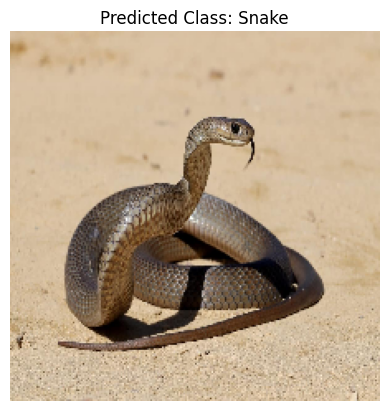

In [ ]:
image_path = '/content/drive/MyDrive/Practice/gyan/9.jpg'
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = image_array / 255.0
prediction = model.predict(image_array)
predicted_class_index = np.argmax(prediction)
class_names = ['Cat', 'Dog', 'Snake']  # Ensure these match your training classes
print(f"Predicted Class: {class_names[predicted_class_index]}")
# Display the image
plt.imshow(image)
plt.title(f"Predicted Class: {class_names[predicted_class_index]}")
plt.axis('off')
plt.show()

**Visualizations**

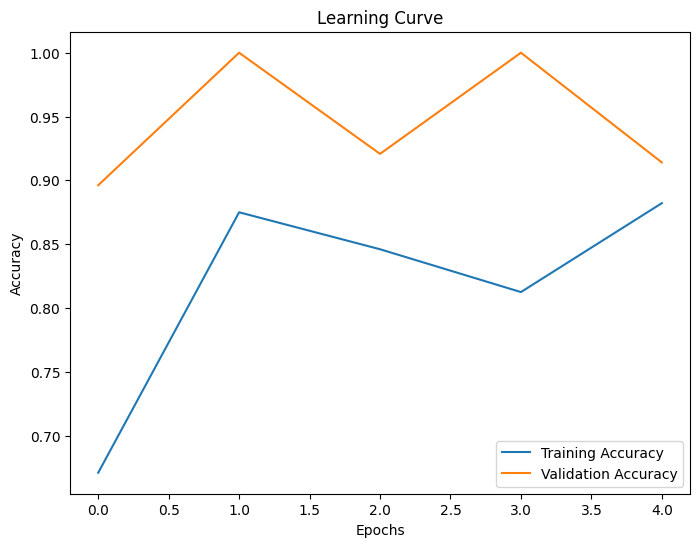

In [ ]:
# Training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

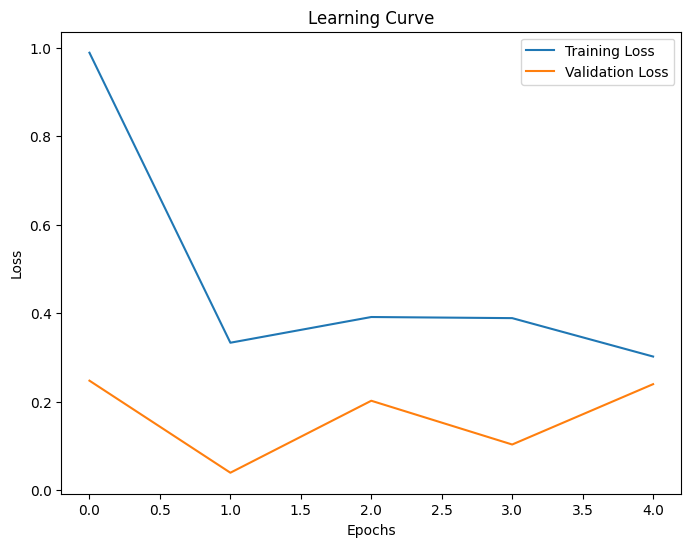

In [ ]:
# Training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

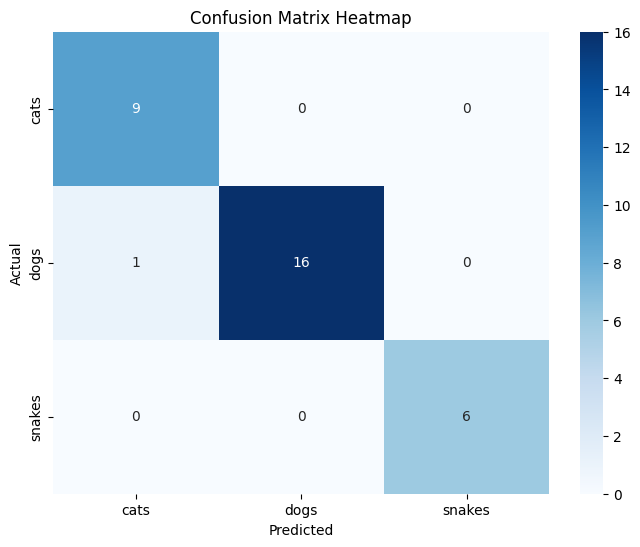

In [ ]:
# Confusion Matrix Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['cats', 'dogs', 'snakes'], yticklabels=['cats', 'dogs', 'snakes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

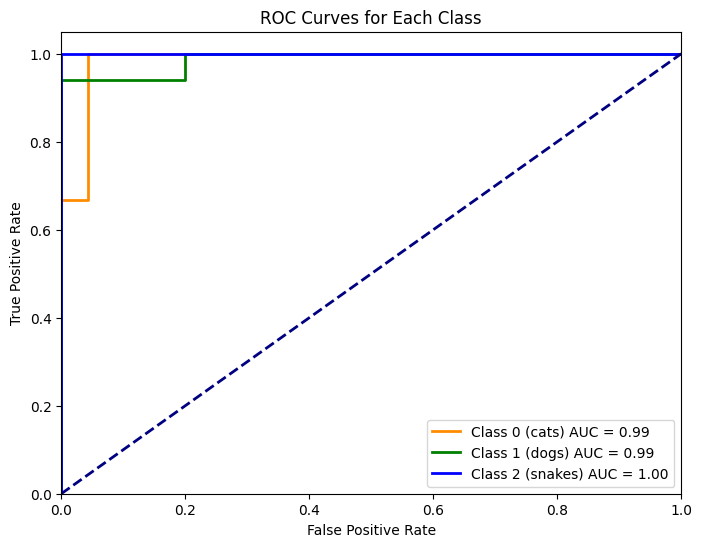

In [ ]:
# Class-wise ROC Curves
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true_test_bin[:, i], y_pred_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} ({["cats", "dogs", "snakes"][i]}) AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

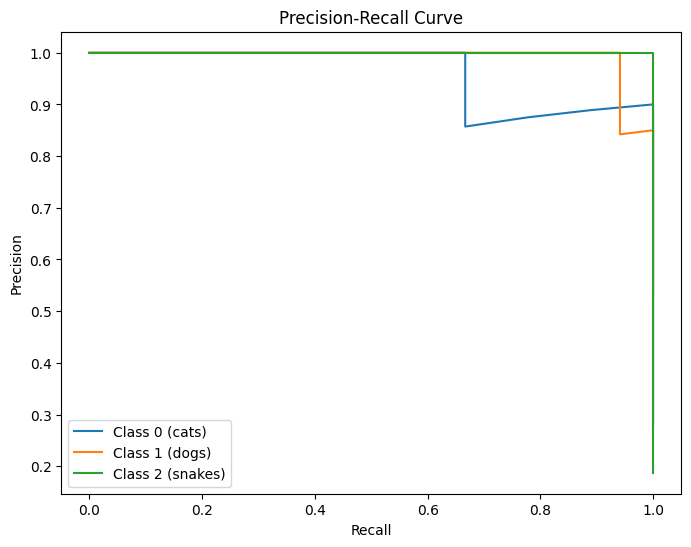

In [ ]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))
for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_test_bin[:, i], y_pred_test[:, i])
    plt.plot(recall, precision, label=f'Class {i} ({["cats", "dogs", "snakes"][i]})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

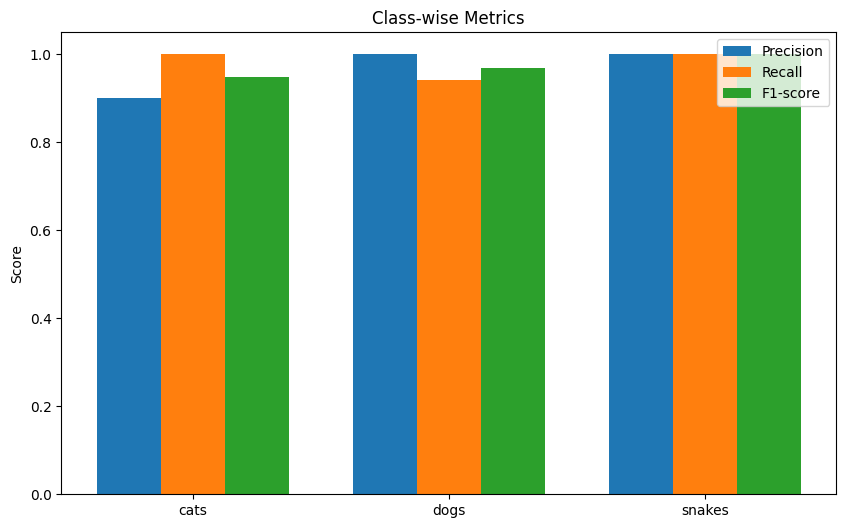

In [ ]:
# Bar Plot of Metrics
import numpy as np

metrics = ['precision', 'recall', 'f1-score']
class_names = ['cats', 'dogs', 'snakes']
values = [
    [report_dict_test[cls][metric] for cls in class_names] for metric in metrics
]

x = np.arange(len(class_names))
width = 0.25  # Bar width

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * width, values[i], width, label=metric.capitalize())

plt.xticks(x + width, class_names)
plt.ylabel('Score')
plt.title('Class-wise Metrics')
plt.legend()
plt.show()

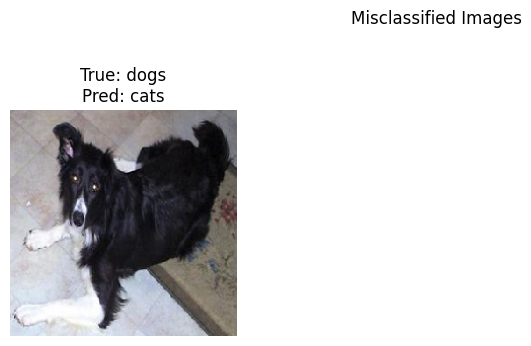

In [ ]:
# Misclassified Images
import matplotlib.pyplot as plt

misclassified_indices = np.where(y_true_test != y_pred_classes_test)[0]

plt.figure(figsize=(12, 10))
for i, index in enumerate(misclassified_indices[:9]):  # Show first 9 misclassified images
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[index])
    plt.title(f'True: {["cats", "dogs", "snakes"][y_true_test[index]]}\nPred: {["cats", "dogs", "snakes"][y_pred_classes_test[index]]}')
    plt.axis('off')
plt.suptitle('Misclassified Images')
plt.show()

<ipython-input-24-586f52e1fa6c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred_classes_test, palette='pastel')


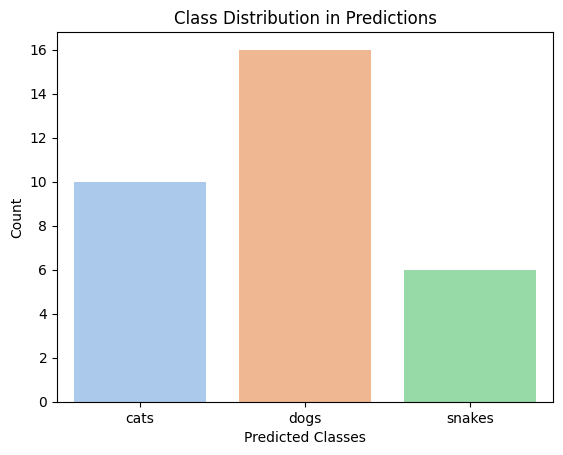

In [ ]:
# Class Distribution in Predictions
import seaborn as sns

sns.countplot(x=y_pred_classes_test, palette='pastel')
plt.xticks(ticks=[0, 1, 2], labels=['cats', 'dogs', 'snakes'])
plt.title('Class Distribution in Predictions')
plt.xlabel('Predicted Classes')
plt.ylabel('Count')
plt.show()

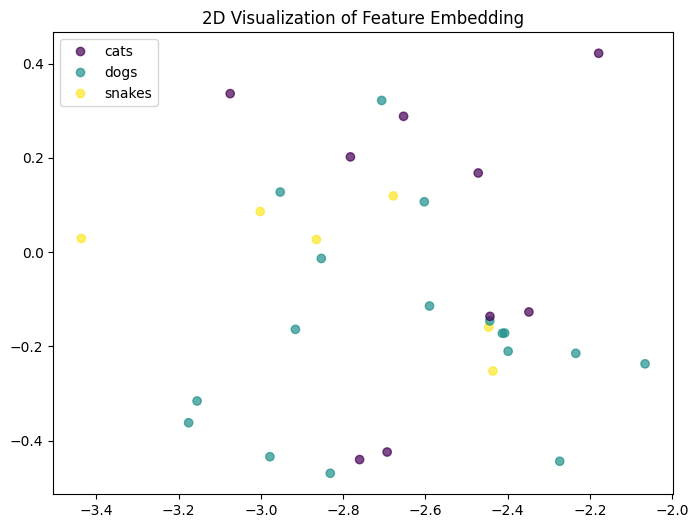

In [ ]:
# t-SNE or PCA for Feature Embedding Visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Use PCA or TSNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(test_images.reshape(len(test_images), -1))  # Flatten images

plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_true_test, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['cats', 'dogs', 'snakes'])
plt.title('2D Visualization of Feature Embedding')
plt.show()